In [1]:
import networkx as nx
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain.callbacks import get_openai_callback
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import UnstructuredPDFLoader, PyPDFLoader

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import sys
import subprocess
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from typing import List, Tuple, Dict
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import spacy
from spacy.util import minibatch, compounding
from spacy.training.example import Example
import random
import heapq


from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import numpy as np

from spacy.cli import download
from spacy.lang.en import English


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # Add the parent directory to the path since we work with notebooks
#from helper_functions import *
#from evaluation.evalute_rag import *

# Load environment variables from a .env file
load_dotenv()

# Set the OpenAI API key environment variable
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [2]:
# Define the DocumentProcessor class
class DocumentProcessor:
    def __init__(self):
        """
        Initializes the DocumentProcessor with a text splitter and OpenAI embeddings.
        
        Attributes:
        - text_splitter: An instance of RecursiveCharacterTextSplitter with specified chunk size and overlap.
        - embeddings: An instance of OpenAIEmbeddings used for embedding documents.
        """
        self.text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
        self.embeddings = OpenAIEmbeddings()

    def process_documents(self, documents):
        """
        Processes a list of documents by splitting them into smaller chunks and creating a vector store.
        
        Args:
        - documents (list of str): A list of documents to be processed.
        
        Returns:
        - tuple: A tuple containing:
          - splits (list of str): The list of split document chunks.
          - vector_store (FAISS): A FAISS vector store created from the split document chunks and their embeddings.
        """
        splits = self.text_splitter.split_documents(documents)
        vector_store = FAISS.from_documents(splits, self.embeddings)
        return splits, vector_store

    def create_embeddings_batch(self, texts, batch_size=32):
        """
        Creates embeddings for a list of texts in batches.
        
        Args:
        - texts (list of str): A list of texts to be embedded.
        - batch_size (int, optional): The number of texts to process in each batch. Default is 32.
        
        Returns:
        - numpy.ndarray: An array of embeddings for the input texts.
        """
        embeddings = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            batch_embeddings = self.embeddings.embed_documents(batch)
            embeddings.extend(batch_embeddings)
        return np.array(embeddings)

    def compute_similarity_matrix(self, embeddings):
        """
        Computes a cosine similarity matrix for a given set of embeddings.
        
        Args:
        - embeddings (numpy.ndarray): An array of embeddings.
        
        Returns:
        - numpy.ndarray: A cosine similarity matrix for the input embeddings.
        """
        return cosine_similarity(embeddings)

In [3]:
from pydantic import BaseModel, Field
# Define the Concepts class
class Concepts(BaseModel):
    #--------------------------------------------
    # What are we doing here?
    # With Pydantic we define a data structure that defines, in turn,
    # how an output from an LLM should look like and what it actually is.
    # So we could instead use a prompt that tells the llm, in this case, to
    # 'return the output as a List of strings that contains the different concepts'.
    # Usually, in LangChain, we use such BaseModel-Classes together with an LLM instance and
    # the method `.with_structured_output()`.
    concepts_list: List[str] = Field(description="List of concepts")

# Define the KnowledgeGraph class
class KnowledgeGraph:
    def __init__(self):
        """
        Initializes the KnowledgeGraph with a graph, lemmatizer, and NLP model.
        
        Attributes:
        - graph: An instance of a networkx Graph.
        - lemmatizer: An instance of WordNetLemmatizer.
        - concept_cache: A dictionary to cache extracted concepts.
        - nlp: An instance of a spaCy NLP model.
        - edges_threshold: A float value that sets the threshold for adding edges based on similarity.
        """
        self.graph = nx.Graph()
        self.lemmatizer = WordNetLemmatizer()
        self.concept_cache = {}
        self.nlp = self._load_spacy_model()
        self.edges_threshold = 0.8

    def build_graph(self, splits, llm, embedding_model):
        """
        Builds the knowledge graph by adding nodes, creating embeddings, extracting concepts, and adding edges.
        
        Args:
        - splits (list): A list of document splits.
        - llm: An instance of a large language model.
        - embedding_model: An instance of an embedding model.
        
        Returns:
        - None
        """
        self._add_nodes(splits)
        embeddings = self._create_embeddings(splits, embedding_model)
        self._extract_concepts(splits, llm)
        self._add_edges(embeddings)

    def _add_nodes(self, splits):
        """
        Adds nodes to the graph from the document splits.
        
        Args:
        - splits (list): A list of document splits.
        
        Returns:
        - None
        """
        for i, split in enumerate(splits):
            self.graph.add_node(i, content=split.page_content)

    def _create_embeddings(self, splits, embedding_model):
        """
        Creates embeddings for the document splits using the embedding model.
        
        Args:
        - splits (list): A list of document splits.
        - embedding_model: An instance of an embedding model.
        
        Returns:
        - numpy.ndarray: An array of embeddings for the document splits.
        """
        texts = [split.page_content for split in splits]
        return embedding_model.embed_documents(texts)

    def _compute_similarities(self, embeddings):
        """
        Computes the cosine similarity matrix for the embeddings.
        
        Args:
        - embeddings (numpy.ndarray): An array of embeddings.
        
        Returns:
        - numpy.ndarray: A cosine similarity matrix for the embeddings.
        """
        return cosine_similarity(embeddings)

    def _load_spacy_model(self):
        """
        Loads the spaCy NLP model, downloading it if necessary.
        
        Args:
        - None
        
        Returns:
        - spacy.Language: An instance of a spaCy NLP model.
        """
        try:
            return spacy.load("en_core_web_sm")
        except OSError:
            print("downloading spaCy model via Linux console: python3 -m spacy download...")
            subprocess.run("python3 -m spacy download en_core_web_sm", shell=True)
            #model = spacy.load("de_core_news_sm")
            # locate the model where it is stored with 'model._path' 
            return spacy.load("en_core_web_sm")

    def _extract_concepts_and_entities(self, content, llm):
        """
        Extracts concepts and named entities from the content using spaCy and a large language model.
        
        Args:
        - content (str): The content from which to extract concepts and entities.
        - llm: An instance of a large language model.
        
        Returns:
        - list: A list of extracted concepts and entities.
        """
        if content in self.concept_cache:
            return self.concept_cache[content]
        
        # Extract named entities using spaCy
        doc = self.nlp(content)
        print("AVAILABLE ENTITIES of SpaCy: {}".format(doc.ents))
        named_entities = [ent.text for ent in doc.ents if ent.label_ in ["PERSON", "ORG", "GPE", "DATE"]]
        
        # Extract general concepts using LLM
        concept_extraction_prompt = PromptTemplate(
            input_variables=["text"],
            template="Extract key concepts (excluding named entities) from the following text:\n\n{text}\n\nKey concepts:"
        )
        concept_chain = concept_extraction_prompt | llm.with_structured_output(Concepts) # apply the pydantic model for the output defined above
        general_concepts = concept_chain.invoke({"text": content}).concepts_list # through the defined pydantic model we are able to retrieve the list of concepts.
        
        # Combine named entities and general concepts
        all_concepts = list(set(named_entities + general_concepts))
        
        self.concept_cache[content] = all_concepts
        return all_concepts

    def _extract_concepts(self, splits, llm):
        """
        Extracts concepts for all document splits using multi-threading.
        
        Args:
        - splits (list): A list of document splits.
        - llm: An instance of a large language model.
        
        Returns:
        - None
        """
        with ThreadPoolExecutor() as executor:
            future_to_node = {executor.submit(self._extract_concepts_and_entities, split.page_content, llm): i 
                              for i, split in enumerate(splits)}
            
            for future in tqdm(as_completed(future_to_node), total=len(splits), desc="Extracting concepts and entities"):
                node = future_to_node[future]
                concepts = future.result()
                self.graph.nodes[node]['concepts'] = concepts

    def _add_edges(self, embeddings):
        """
        Adds edges to the graph based on the similarity of embeddings and shared concepts.
        
        Args:
        - embeddings (numpy.ndarray): An array of embeddings for the document splits.
        
        Returns:
        - None
        """
        similarity_matrix = self._compute_similarities(embeddings)
        num_nodes = len(self.graph.nodes)
        
        for node1 in tqdm(range(num_nodes), desc="Adding edges"):
            for node2 in range(node1 + 1, num_nodes):
                similarity_score = similarity_matrix[node1][node2]
                if similarity_score > self.edges_threshold:
                    shared_concepts = set(self.graph.nodes[node1]['concepts']) & set(self.graph.nodes[node2]['concepts'])
                    edge_weight = self._calculate_edge_weight(node1, node2, similarity_score, shared_concepts)
                    self.graph.add_edge(node1, node2, weight=edge_weight, 
                                        similarity=similarity_score,
                                        shared_concepts=list(shared_concepts))

    def _calculate_edge_weight(self, node1, node2, similarity_score, shared_concepts, alpha=0.7, beta=0.3):
        """
        Calculates the weight of an edge based on similarity score and shared concepts.
        
        Args:
        - node1 (int): The first node.
        - node2 (int): The second node.
        - similarity_score (float): The similarity score between the nodes.
        - shared_concepts (set): The set of shared concepts between the nodes.
        - alpha (float, optional): The weight of the similarity score. Default is 0.7.
        - beta (float, optional): The weight of the shared concepts. Default is 0.3.
        
        Returns:
        - float: The calculated weight of the edge.
        """
        max_possible_shared = min(len(self.graph.nodes[node1]['concepts']), len(self.graph.nodes[node2]['concepts']))
        normalized_shared_concepts = len(shared_concepts) / max_possible_shared if max_possible_shared > 0 else 0
        return alpha * similarity_score + beta * normalized_shared_concepts

    def _lemmatize_concept(self, concept):
        """
        Lemmatizes a given concept.
        
        Args:
        - concept (str): The concept to be lemmatized.
        
        Returns:
        - str: The lemmatized concept.
        """
        return ' '.join([self.lemmatizer.lemmatize(word) for word in concept.lower().split()])

In [4]:
# Define the AnswerCheck class
class AnswerCheck(BaseModel):
    is_complete: bool = Field(description="Whether the current context provides a complete answer to the query")
    answer: str = Field(description="The current answer based on the context, if any")

# Define the QueryEngine class
class QueryEngine:
    def __init__(self, vector_store, knowledge_graph, llm):
        self.vector_store = vector_store
        self.knowledge_graph = knowledge_graph
        self.llm = llm
        self.max_context_length = 4000
        self.answer_check_chain = self._create_answer_check_chain()

    def _create_answer_check_chain(self):
        """
        Creates a chain to check if the context provides a complete answer to the query.
        
        Args:
        - None
        
        Returns:
        - Chain: A chain to check if the context provides a complete answer.
        """
        answer_check_prompt = PromptTemplate(
            input_variables=["query", "context"],
            template="Given the query: '{query}'\n\nAnd the current context:\n{context}\n\nDoes this context provide a complete answer to the query? If yes, provide the answer. If no, state that the answer is incomplete.\n\nIs complete answer (Yes/No):\nAnswer (if complete):"
        )
        return answer_check_prompt | self.llm.with_structured_output(AnswerCheck)

    def _check_answer(self, query: str, context: str) -> Tuple[bool, str]:
        """
        Checks if the current context provides a complete answer to the query.
        
        Args:
        - query (str): The query to be answered.
        - context (str): The current context.
        
        Returns:
        - tuple: A tuple containing:
          - is_complete (bool): Whether the context provides a complete answer.
          - answer (str): The answer based on the context, if complete.
        """
        response = self.answer_check_chain.invoke({"query": query, "context": context})
        return response.is_complete, response.answer

  

    def _expand_context(self, query: str, relevant_docs) -> Tuple[str, List[int], Dict[int, str], str]:
        """
        Expands the context by traversing the knowledge graph using a Dijkstra-like approach.
        
        This method implements a modified version of Dijkstra's algorithm to explore the knowledge graph,
        prioritizing the most relevant and strongly connected information. The algorithm works as follows:

        1. Initialize:
           - Start with nodes corresponding to the most relevant documents.
           - Use a priority queue to manage the traversal order, where priority is based on connection strength.
           - Maintain a dictionary of best known "distances" (inverse of connection strengths) to each node.

        2. Traverse:
           - Always explore the node with the highest priority (strongest connection) next.
           - For each node, check if we've found a complete answer.
           - Explore the node's neighbors, updating their priorities if a stronger connection is found.

        3. Concept Handling:
           - Track visited concepts to guide the exploration towards new, relevant information.
           - Expand to neighbors only if they introduce new concepts.

        4. Termination:
           - Stop if a complete answer is found.
           - Continue until the priority queue is empty (all reachable nodes explored).

        This approach ensures that:
        - We prioritize the most relevant and strongly connected information.
        - We explore new concepts systematically.
        - We find the most relevant answer by following the strongest connections in the knowledge graph.

        Args:
        - query (str): The query to be answered.
        - relevant_docs (List[Document]): A list of relevant documents to start the traversal.

        Returns:
        - tuple: A tuple containing:
          - expanded_context (str): The accumulated context from traversed nodes.
          - traversal_path (List[int]): The sequence of node indices visited.
          - filtered_content (Dict[int, str]): A mapping of node indices to their content.
          - final_answer (str): The final answer found, if any.
        """
        # Initialize variables
        expanded_context = ""
        traversal_path = []
        visited_concepts = set()
        filtered_content = {}
        final_answer = ""
        
        priority_queue = []
        distances = {}  # Stores the best known "distance" (inverse of connection strength) to each node
        
        print("\nTraversing the knowledge graph:")
        
        # Initialize priority queue with closest nodes from relevant docs
        for doc in relevant_docs:
            # Find the most similar node in the knowledge graph for each relevant document
            closest_nodes = self.vector_store.similarity_search_with_score(doc.page_content, k=1)
            closest_node_content, similarity_score = closest_nodes[0]
            
            # Get the corresponding node in our knowledge graph
            closest_node = next(n for n in self.knowledge_graph.graph.nodes if self.knowledge_graph.graph.nodes[n]['content'] == closest_node_content.page_content)
            
            # Initialize priority (inverse of similarity score for min-heap behavior)
            priority = 1 / similarity_score
            heapq.heappush(priority_queue, (priority, closest_node))
            distances[closest_node] = priority
        
        step = 0
        while priority_queue:
            # Get the node with the highest priority (lowest distance value)
            current_priority, current_node = heapq.heappop(priority_queue)
            
            # Skip if we've already found a better path to this node
            if current_priority > distances.get(current_node, float('inf')):
                continue
            
            if current_node not in traversal_path:
                step += 1
                traversal_path.append(current_node)
                node_content = self.knowledge_graph.graph.nodes[current_node]['content']
                node_concepts = self.knowledge_graph.graph.nodes[current_node]['concepts']
                
                # Add node content to our accumulated context
                filtered_content[current_node] = node_content
                expanded_context += "\n" + node_content if expanded_context else node_content
                
                # Log the current step for debugging and visualization
                print(f"\nStep {step} - Node {current_node}:")
                print(f"Content: {node_content[:100]}...") 
                print(f"Concepts: {', '.join(node_concepts)}")
                print("-" * 50)
                
                # Check if we have a complete answer with the current context
                is_complete, answer = self._check_answer(query, expanded_context)
                if is_complete:
                    final_answer = answer
                    break
                
                # Process the concepts of the current node
                node_concepts_set = set(self.knowledge_graph._lemmatize_concept(c) for c in node_concepts)
                if not node_concepts_set.issubset(visited_concepts):
                    visited_concepts.update(node_concepts_set)
                    
                    # Explore neighbors
                    for neighbor in self.knowledge_graph.graph.neighbors(current_node):
                        edge_data = self.knowledge_graph.graph[current_node][neighbor]
                        edge_weight = edge_data['weight']
                        
                        # Calculate new distance (priority) to the neighbor
                        # Note: We use 1 / edge_weight because higher weights mean stronger connections
                        distance = current_priority + (1 / edge_weight)
                        
                        # If we've found a stronger connection to the neighbor, update its distance
                        if distance < distances.get(neighbor, float('inf')):
                            distances[neighbor] = distance
                            heapq.heappush(priority_queue, (distance, neighbor))
                            
                            # Process the neighbor node if it's not already in our traversal path
                            if neighbor not in traversal_path:
                                step += 1
                                traversal_path.append(neighbor)
                                neighbor_content = self.knowledge_graph.graph.nodes[neighbor]['content']
                                neighbor_concepts = self.knowledge_graph.graph.nodes[neighbor]['concepts']
                                
                                filtered_content[neighbor] = neighbor_content
                                expanded_context += "\n" + neighbor_content if expanded_context else neighbor_content
                                
                                # Log the neighbor node information
                                print(f"\nStep {step} - Node {neighbor} (neighbor of {current_node}):")
                                print(f"Content: {neighbor_content[:100]}...")
                                print(f"Concepts: {', '.join(neighbor_concepts)}")
                                print("-" * 50)
                                
                                # Check if we have a complete answer after adding the neighbor's content
                                is_complete, answer = self._check_answer(query, expanded_context)
                                if is_complete:
                                    final_answer = answer
                                    break
                                
                                # Process the neighbor's concepts
                                neighbor_concepts_set = set(self.knowledge_graph._lemmatize_concept(c) for c in neighbor_concepts)
                                if not neighbor_concepts_set.issubset(visited_concepts):
                                    visited_concepts.update(neighbor_concepts_set)
                
                # If we found a final answer, break out of the main loop
                if final_answer:
                    break

        # If we haven't found a complete answer, generate one using the LLM
        if not final_answer:
            print("\nGenerating final answer...")
            response_prompt = PromptTemplate(
                input_variables=["query", "context"],
                template="Based on the following context, please answer the query.\n\nContext: {context}\n\nQuery: {query}\n\nAnswer:"
            )
            response_chain = response_prompt | self.llm
            input_data = {"query": query, "context": expanded_context}
            final_answer = response_chain.invoke(input_data)

        return expanded_context, traversal_path, filtered_content, final_answer

    def query(self, query: str) -> Tuple[str, List[int], Dict[int, str]]:
        """
        Processes a query by retrieving relevant documents, expanding the context, and generating the final answer.
        
        Args:
        - query (str): The query to be answered.
        
        Returns:
        - tuple: A tuple containing:
          - final_answer (str): The final answer to the query.
          - traversal_path (list): The traversal path of nodes in the knowledge graph.
          - filtered_content (dict): The filtered content of nodes.
        """
        with get_openai_callback() as cb:
            print(f"\nProcessing query: {query}")
            relevant_docs = self._retrieve_relevant_documents(query)
            expanded_context, traversal_path, filtered_content, final_answer = self._expand_context(query, relevant_docs)
            
            if not final_answer:
                print("\nGenerating final answer...")
                response_prompt = PromptTemplate(
                    input_variables=["query", "context"],
                    template="Based on the following context, please answer the query.\n\nContext: {context}\n\nQuery: {query}\n\nAnswer:"
                )
                
                response_chain = response_prompt | self.llm
                input_data = {"query": query, "context": expanded_context}
                response = response_chain.invoke(input_data)
                final_answer = response
            else:
                print("\nComplete answer found during traversal.")
            
            print(f"\nFinal Answer: {final_answer}")
            print(f"\nTotal Tokens: {cb.total_tokens}")
            print(f"Prompt Tokens: {cb.prompt_tokens}")
            print(f"Completion Tokens: {cb.completion_tokens}")
            print(f"Total Cost (USD): ${cb.total_cost}")
        
        return final_answer, traversal_path, filtered_content

    def _retrieve_relevant_documents(self, query: str):
        """
        Retrieves relevant documents based on the query using the vector store.
        
        Args:
        - query (str): The query to be answered.
        
        Returns:
        - list: A list of relevant documents.
        """
        print("\nRetrieving relevant documents...")
        retriever = self.vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 5})
        compressor = LLMChainExtractor.from_llm(self.llm)
        compression_retriever = ContextualCompressionRetriever(base_compressor=compressor, base_retriever=retriever)
        return compression_retriever.invoke(query)

In [9]:
# Define the Visualizer class
class Visualizer:
    @staticmethod
    def visualize_traversal(graph, traversal_path):
        """
        Visualizes the traversal path on the knowledge graph with nodes, edges, and traversal path highlighted.

        Args:
        - graph (networkx.Graph): The knowledge graph containing nodes and edges.
        - traversal_path (list of int): The list of node indices representing the traversal path.

        Returns:
        - None
        """
        traversal_graph = nx.DiGraph()
        
        # Add nodes and edges from the original graph
        for node in graph.nodes():
            traversal_graph.add_node(node)
        for u, v, data in graph.edges(data=True):
            traversal_graph.add_edge(u, v, **data)
        
        fig, ax = plt.subplots(figsize=(16, 12))
        
        # Generate positions for all nodes
        pos = nx.spring_layout(traversal_graph, k=1, iterations=50)
        
        # Draw regular edges with color based on weight
        edges = traversal_graph.edges()
        edge_weights = [traversal_graph[u][v].get('weight', 0.5) for u, v in edges]
        nx.draw_networkx_edges(traversal_graph, pos, 
                               edgelist=edges,
                               edge_color=edge_weights,
                               edge_cmap=plt.cm.Blues,
                               width=2,
                               ax=ax)
        
        # Draw nodes
        nx.draw_networkx_nodes(traversal_graph, pos, 
                               node_color='lightblue',
                               node_size=3000,
                               ax=ax)
        
        # Draw traversal path with curved arrows
        edge_offset = 0.1
        for i in range(len(traversal_path) - 1):
            start = traversal_path[i]
            end = traversal_path[i + 1]
            start_pos = pos[start]
            end_pos = pos[end]
            
            # Calculate control point for curve
            mid_point = ((start_pos[0] + end_pos[0]) / 2, (start_pos[1] + end_pos[1]) / 2)
            control_point = (mid_point[0] + edge_offset, mid_point[1] + edge_offset)
            
            # Draw curved arrow
            arrow = patches.FancyArrowPatch(start_pos, end_pos,
                                            connectionstyle=f"arc3,rad={0.3}",
                                            color='red',
                                            arrowstyle="->",
                                            mutation_scale=20,
                                            linestyle='--',
                                            linewidth=2,
                                            zorder=4)
            ax.add_patch(arrow)
        
        # Prepare labels for the nodes
        labels = {}
        for i, node in enumerate(traversal_path):
            concepts = graph.nodes[node].get('concepts', [])
            label = f"{i + 1}. {concepts[0] if concepts else ''}"
            labels[node] = label
        
        for node in traversal_graph.nodes():
            if node not in labels:
                concepts = graph.nodes[node].get('concepts', [])
                labels[node] = concepts[0] if concepts else ''
        
        # Draw labels
        nx.draw_networkx_labels(traversal_graph, pos, labels, font_size=8, font_weight="bold", ax=ax)
        
        # Highlight start and end nodes
        start_node = traversal_path[0]
        end_node = traversal_path[-1]
        
        nx.draw_networkx_nodes(traversal_graph, pos, 
                               nodelist=[start_node], 
                               node_color='lightgreen', 
                               node_size=3000,
                               ax=ax)
        
        nx.draw_networkx_nodes(traversal_graph, pos, 
                               nodelist=[end_node], 
                               node_color='lightcoral', 
                               node_size=3000,
                               ax=ax)
        
        ax.set_title("Graph Traversal Flow")
        ax.axis('off')
        
        # Add colorbar for edge weights
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
        cbar.set_label('Edge Weight', rotation=270, labelpad=15)
        
        # Add legend
        regular_line = plt.Line2D([0], [0], color='blue', linewidth=2, label='Regular Edge')
        traversal_line = plt.Line2D([0], [0], color='red', linewidth=2, linestyle='--', label='Traversal Path')
        start_point = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=15, label='Start Node')
        end_point = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightcoral', markersize=15, label='End Node')
        legend = plt.legend(handles=[regular_line, traversal_line, start_point, end_point], loc='upper left', bbox_to_anchor=(0, 1), ncol=2)
        legend.get_frame().set_alpha(0.8)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def print_filtered_content(traversal_path, filtered_content):
        """
        Prints the filtered content of visited nodes in the order of traversal.

        Args:
        - traversal_path (list of int): The list of node indices representing the traversal path.
        - filtered_content (dict of int: str): A dictionary mapping node indices to their filtered content.

        Returns:
        - None
        """
        print("\nFiltered content of visited nodes in order of traversal:")
        for i, node in enumerate(traversal_path):
            print(f"\nStep {i + 1} - Node {node}:")
            print(f"Filtered Content: {filtered_content.get(node, 'No filtered content available')[:200]}...")  # Print first 200 characters
            print("-" * 50)

In [10]:
class GraphRAG:
    def __init__(self):
        """
        Initializes the GraphRAG system with components for document processing, knowledge graph construction,
        querying, and visualization.
        
        Attributes:
        - llm: An instance of a large language model (LLM) for generating responses.
        - embedding_model: An instance of an embedding model for document embeddings.
        - document_processor: An instance of the DocumentProcessor class for processing documents.
        - knowledge_graph: An instance of the KnowledgeGraph class for building and managing the knowledge graph.
        - query_engine: An instance of the QueryEngine class for handling queries (initialized as None).
        - visualizer: An instance of the Visualizer class for visualizing the knowledge graph traversal.
        """
        self.llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini", max_tokens=4000)
        self.embedding_model = OpenAIEmbeddings()
        self.document_processor = DocumentProcessor()
        self.knowledge_graph = KnowledgeGraph()
        self.query_engine = None
        self.visualizer = Visualizer()

    def process_documents(self, documents):
        """
        Processes a list of documents by splitting them into chunks, embedding them, and building a knowledge graph.
        
        Args:
        - documents (list of str): A list of documents to be processed.
        
        Returns:
        - None
        """
        splits, vector_store = self.document_processor.process_documents(documents)
        self.knowledge_graph.build_graph(splits, self.llm, self.embedding_model)
        self.query_engine = QueryEngine(vector_store, self.knowledge_graph, self.llm)

    def query(self, query: str):
        """
        Handles a query by retrieving relevant information from the knowledge graph and visualizing the traversal path.
        
        Args:
        - query (str): The query to be answered.
        
        Returns:
        - str: The response to the query.
        """
        response, traversal_path, filtered_content = self.query_engine.query(query)
        
        if traversal_path:
            self.visualizer.visualize_traversal(self.knowledge_graph.graph, traversal_path)
        else:
            print("No traversal path to visualize.")
        
        return response

In [11]:
path = "./src/data/20200414_IMF_Preliminary World Economic Outlook Report.pdf"
loader = PyPDFLoader(path)
docs = loader.load()

In [12]:
graph_rag = GraphRAG()

In [13]:
graph_rag.process_documents(docs)

Adding edges: 100%|██████████| 171/171 [00:00<00:00, 1650.26it/s]



Processing query: what was the economic outlook for Germany in 2020?

Retrieving relevant documents...

Traversing the knowledge graph:

Step 1 - Node 146:
Content: Spain 2.0 –8.0 4.3 0.7 –0.3 0.7 2.0 2.2 2.4 14.1 20.8 17.5
Netherlands 1.8 –7.5 3.0 2.7 0.5 1.2 10.9...
Concepts: public debt, Latvia, financial stability, Estonia 4.3, Ireland, economic performance, economic recovery, labor market, inflation, economic indicators, consumer spending, Austria 1.6, Lithuania, export and import, monetary policies, fiscal policies, GDP growth, unemployment rates, Spain, economic forecasts, Slovenia 2.4, economic trends, Finland 1.0, trade balance, Portugal 2.2, Netherlands, regional economic differences, investment, Luxembourg, Belgium, Greece 1.9, economic resilience, economic challenges
--------------------------------------------------

Step 2 - Node 5 (neighbor of 146):
Content: $37.87 a barrel in 2021 and will remain unchanged in real terms over the medium term; that the six-m...
Concepts:

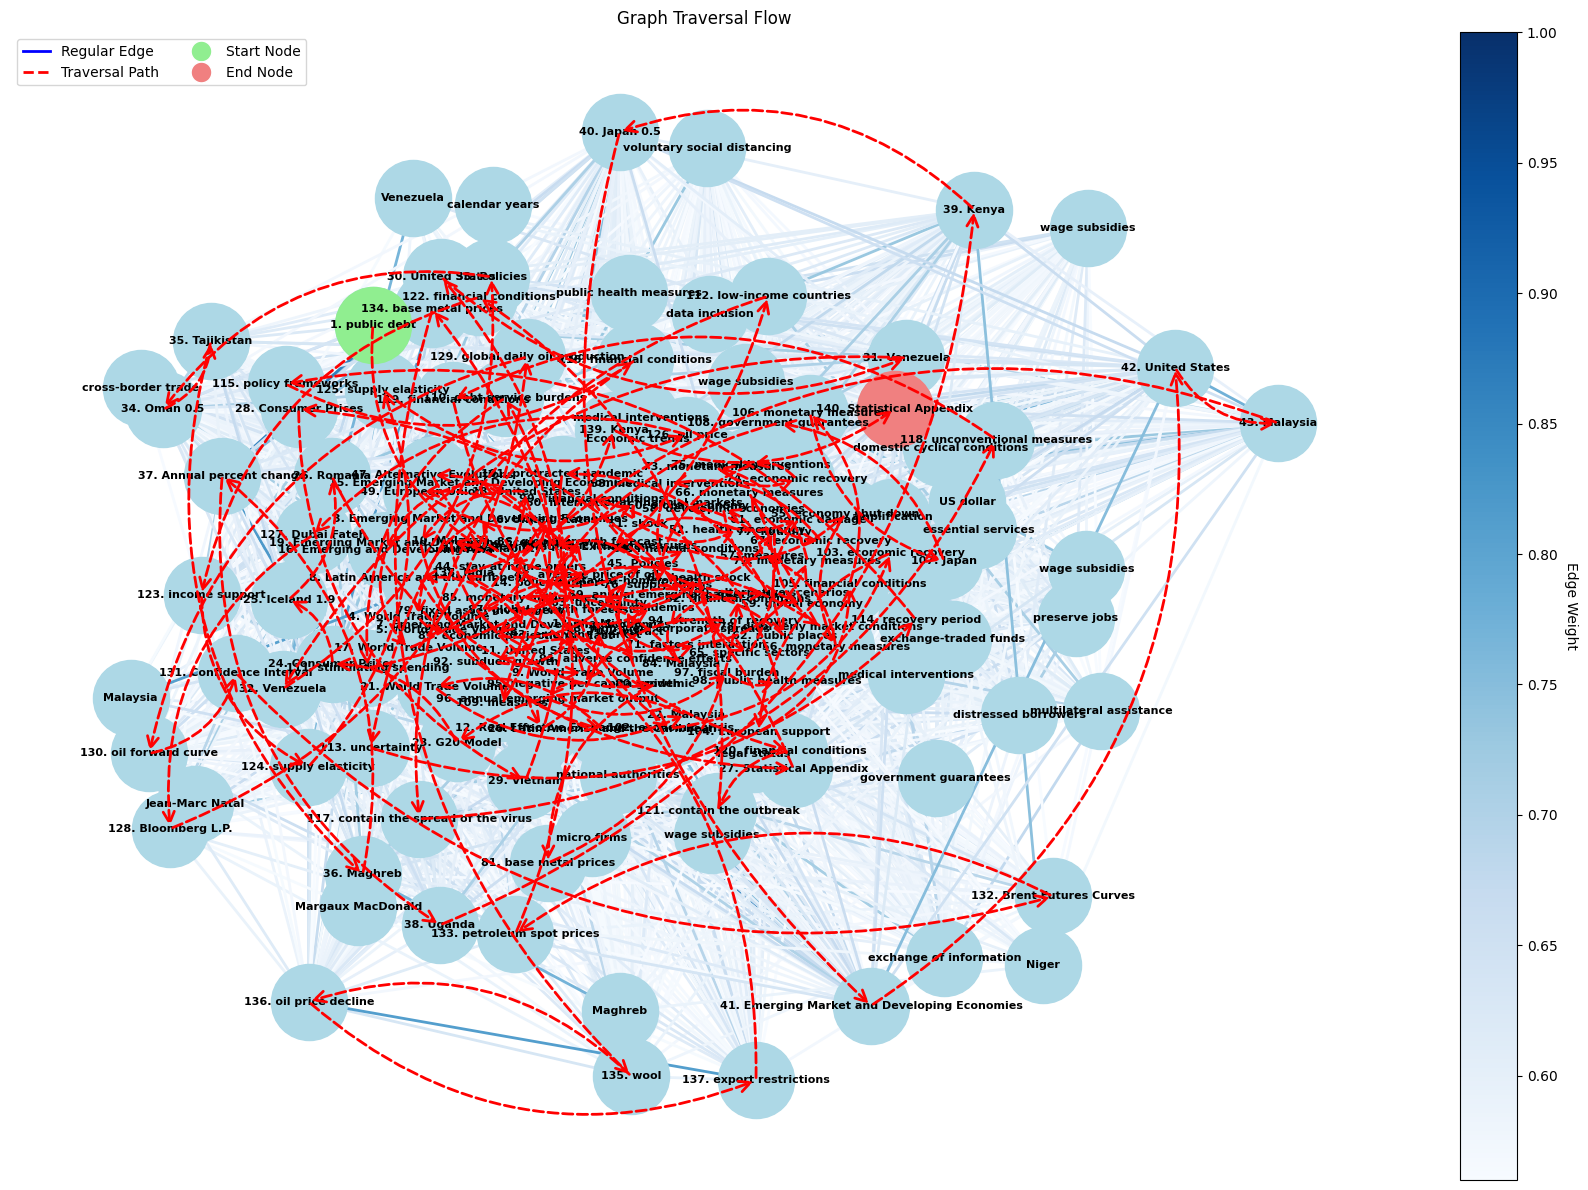

In [14]:
query="what was the economic outlook for Germany in 2020?"
response = graph_rag.query(query=query)

In [2]:
#-----------------------------------------
# CUSTOMIZING SPACY MODEL. NLP TRAINING.
# source: https://www.machinelearningplus.com/nlp/training-custom-ner-model-in-spacy/#:~:text=8.-,Training%20completely%20new%20entity%20type%20in%20spaCy,-In%20previous%20section
TRAIN_DATA = [
("The AKHMAT Special Forces conducted a daring operation in the eastern region.",
{"entities": [(4, 25, "MILITARY_UNIT")]}),
("Soldiers from the 24th Mechanized Brigade fortified their positions near Bakhmut.",
{"entities": [(18, 41, "MILITARY_UNIT")]}),
("The 128th Mountain Assault Brigade is renowned for its resilience in mountainous warfare.",
{"entities": [(4, 34, "MILITARY_UNIT")]}),
("During the counteroffensive, the 92nd Mechanized Brigade advanced significantly.",
{"entities": [(32, 56, "MILITARY_UNIT")]}),
("The 1st Presidential Brigade provides critical support during ceremonial events and combat operations.",
{"entities": [(4, 28, "MILITARY_UNIT")]}),
("Engineers from the 211th Pontoon Bridge Brigade built a crossing over the Dnipro River.",
{"entities": [(19, 47, "MILITARY_UNIT")]}),
("The 79th Air Assault Brigade successfully repelled an enemy attack.",
{"entities": [(4, 29, "MILITARY_UNIT")]}),
("Troops of the 57th Motorized Infantry Brigade maintained defensive lines under heavy shelling.",
{"entities": [(14, 45, "MILITARY_UNIT")]}),
("The 3rd Tank Brigade was deployed to reinforce key positions in the south.",
{"entities": [(4, 21, "MILITARY_UNIT")]}),
("A reconnaissance mission was completed by the 73rd Naval Special Operations Center.",
{"entities": [(46, 82, "MILITARY_UNIT")]}),
("The 30th Mechanized Brigade has played a pivotal role in recent battles.",
{"entities": [(4, 27, "MILITARY_UNIT")]}),
("The 36th Marine Brigade conducted amphibious training near the Black Sea coast.",
{"entities": [(4, 24, "MILITARY_UNIT")]}),
("Members of the 503rd Separate Marine Battalion were awarded for their bravery.",
{"entities": [(15, 46, "MILITARY_UNIT")]}),
("The 10th Mountain Assault Brigade launched a pre-dawn offensive.",
{"entities": [(4, 33, "MILITARY_UNIT")]}),
("A strategic river crossing was established by the 12th Engineer Brigade.",
{"entities": [(50, 71, "MILITARY_UNIT")]}),
("The 17th Tank Brigade spearheaded the breakthrough on the western flank.",
{"entities": [(4, 22, "MILITARY_UNIT")]}),
("Soldiers from the 58th Motorized Infantry Brigade demonstrated exceptional courage.",
{"entities": [(18, 49, "MILITARY_UNIT")]}),
("The 59th Motorized Brigade was involved in heavy fighting in the Donetsk region.",
{"entities": [(4, 26, "MILITARY_UNIT")]}),
("Combat engineers of the 14th Mechanized Brigade repaired critical infrastructure.",
{"entities": [(24, 47, "MILITARY_UNIT")]}),
("The 72nd Mechanized Brigade has consistently held its ground despite enemy advances.",
{"entities": [(4, 27, "MILITARY_UNIT")]}),
("The 93rd Mechanized Brigade is celebrated for its key contributions to recent successes.",
{"entities": [(4, 27, "MILITARY_UNIT")]}),
("During an assault, the 80th Air Assault Brigade captured key objectives.",
{"entities": [(23, 48, "MILITARY_UNIT")]}),
("The 81st Airmobile Brigade completed a high-risk deployment to the frontlines.",
{"entities": [(4, 27, "MILITARY_UNIT")]}),
("Paratroopers from the 25th Airborne Brigade neutralized multiple enemy positions.",
{"entities": [(21, 44, "MILITARY_UNIT")]}),
("The 1st Tank Brigade reinforced defensive positions around Kharkiv.",
{"entities": [(4, 20, "MILITARY_UNIT")]}),
("The 18th Coastal Defense Battalion conducted patrols along the coastline.",
{"entities": [(4, 34, "MILITARY_UNIT")]}),
("A successful counterattack was led by the 93rd Mechanized Brigade.",
{"entities": [(42, 65, "MILITARY_UNIT")]}),
("The 77th Airmobile Brigade executed an aerial insertion into hostile territory.",
{"entities": [(4, 27, "MILITARY_UNIT")]}),
("Special forces of the 140th Special Operations Unit eliminated high-value targets.",
{"entities": [(22, 51, "MILITARY_UNIT")]}),
("The 44th Artillery Brigade provided long-range fire support during the operation.",
{"entities": [(4, 26, "MILITARY_UNIT")]}),
("The 38th Naval Infantry Brigade secured key points along the riverbank.",
{"entities": [(4, 31, "MILITARY_UNIT")]}),
("Soldiers of the 43rd Heavy Artillery Brigade targeted enemy supply lines.",
{"entities": [(16, 44, "MILITARY_UNIT")]}),
("The 82nd Air Assault Brigade is trained for rapid response operations.",
{"entities": [(4, 29, "MILITARY_UNIT")]}),
("Recon elements from the 75th Ranger Division gathered critical intelligence.",
{"entities": [(24, 44, "MILITARY_UNIT")]}),
("Engineers of the 21st Separate Engineering Battalion constructed defensive barriers.",
{"entities": [(16, 52, "MILITARY_UNIT")]}),
("The 35th Marine Brigade carried out coastal operations under enemy fire.",
{"entities": [(4, 24, "MILITARY_UNIT")]}),
("The 45th Air Defense Brigade intercepted incoming aerial threats.",
{"entities": [(4, 28, "MILITARY_UNIT")]}),
("The 50th Signal Brigade ensured uninterrupted communication across units.",
{"entities": [(4, 23, "MILITARY_UNIT")]}),
("The 55th Artillery Brigade delivered precision strikes against enemy fortifications.",
{"entities": [(4, 26, "MILITARY_UNIT")]}),
("Troops from the 19th Rocket Artillery Brigade launched coordinated attacks.",
{"entities": [(16, 45, "MILITARY_UNIT")]}),
("The 41st Engineering Division played a crucial role in clearing minefields.",
{"entities": [(4, 30, "MILITARY_UNIT")]}),
("During the operation, the GRUT Mechanized Unit secured a vital supply route.",
{"entities": [(26, 47, "MILITARY_UNIT")]}),
("The 39th Infantry Brigade conducted joint exercises with allied forces.",
{"entities": [(4, 25, "MILITARY_UNIT")]}),
("A swift raid was conducted by the 31st Mechanized Brigade in the northern sector.",
{"entities": [(34, 57, "MILITARY_UNIT")]}),
("The 22nd Mechanized Brigade has maintained control of key areas in the east.",
{"entities": [(4, 27, "MILITARY_UNIT")]}),
("The 29th Motorized Brigade intercepted an enemy convoy near the border.",
{"entities": [(4, 26, "MILITARY_UNIT")]}),
("The 67th Infantry Brigade participated in the defense of key urban centers.",
{"entities": [(4, 25, "MILITARY_UNIT")]}),
("The 101st Territorial Defense Brigade has been critical in protecting civilians.",
{"entities": [(4, 37, "MILITARY_UNIT")]}),
("The 16th Tank Brigade moved swiftly to reinforce embattled positions.",
{"entities": [(4, 21, "MILITARY_UNIT")]}),
("A crucial supply line was secured by the 47th Mechanized Brigade.",
{"entities": [(41, 64, "MILITARY_UNIT")]}),
]

In [3]:
for e in range(0, len(TRAIN_DATA)):
    start = TRAIN_DATA[e][1]["entities"][0][0]
    end = TRAIN_DATA[e][1]["entities"][0][1]
    print(f"\n-----------------------------------------------------\nAt index {e} in list the military unit is: {TRAIN_DATA[e][0][start:end]}")


-----------------------------------------------------
At index 0 in list the military unit is: AKHMAT Special Forces

-----------------------------------------------------
At index 1 in list the military unit is: 24th Mechanized Brigade

-----------------------------------------------------
At index 2 in list the military unit is: 128th Mountain Assault Brigade

-----------------------------------------------------
At index 3 in list the military unit is:  92nd Mechanized Brigade

-----------------------------------------------------
At index 4 in list the military unit is: 1st Presidential Brigade

-----------------------------------------------------
At index 5 in list the military unit is: 211th Pontoon Bridge Brigade

-----------------------------------------------------
At index 6 in list the military unit is: 79th Air Assault Brigade 

-----------------------------------------------------
At index 7 in list the military unit is: 57th Motorized Infantry Brigade

-----------------

In [4]:
def train_spacy_ner_model(new_label: str, train_data: List[tuple], lang: str="en"):
    if new_label != train_data[0][1]["entities"][0][2]:
        raise ValueError("The given NER label does not fit your training data!")
    if lang == "en":
        model = "en_core_web_sm"
    else:
        model = "de_core_news_sm"
    # load spacy language model
    nlp=spacy.load(model) 
    # load the ner component
    ner=nlp.get_pipe('ner')
    # previous labels
    original_labels = ner.labels
    # add the new label to the namespace
    ner.add_label(new_label)
    # get the optimizer from the spacy training
    optimizer = nlp.resume_training()
    # List of pipes you want to train
    pipes_to_be_trained = ["ner"]
    # List of pipes which should remain unaffected in training
    disabled_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipes_to_be_trained]
    print("disabled pipes are: {}".format(disabled_pipes))
    
    #------------------------------------------------------
    # Training
    # Begin training by disabling other pipeline components
    with nlp.disable_pipes(*disabled_pipes) :
        sizes = compounding(1.0, 4.0, 1.001)
        # Training for 30 iterations     
        for r in range(30):
            # shuffle examples before training
            random.shuffle(train_data)
            # batch up the examples using spaCy's minibatch
            batches = minibatch(train_data, size=sizes)
            # ictionary to store losses
            losses = {}
            for batch in batches:
                for text, annotations in batch:
                    # create example instance
                    doc = nlp.make_doc(text=text)
                    example = Example.from_dict(doc, annotations)
                    # Calling update() over the iteration
                    nlp.update([example], sgd=optimizer, drop=0.35, losses=losses)
                    print("Losses", losses)
    # labels after retraining
    retrained_labels = nlp.get_pipe("ner").labels
    # Check of previous labels have been preserved
    missing_labels = set(original_labels) - set(retrained_labels)
    if missing_labels:
        print(f"Warning: Missing labels after retraining - {missing_labels}")
    MODEL_DIR = os.path.join(os.getcwd(), 'models/custom_spacy_model')
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR, exist_ok=True)
    nlp.meta['name'] = 'custom_ner'  # rename model
    nlp.to_disk(MODEL_DIR)
    print("Saved model to:{}".format(MODEL_DIR))
    return nlp

In [5]:
nlp_test = train_spacy_ner_model(new_label="MILITARY_UNIT", train_data=TRAIN_DATA, lang="en")

disabled pipes are: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']
Losses {'ner': 1.5628677774866575}
Losses {'ner': 3.3428522712149467}
Losses {'ner': 3.345997617005815}
Losses {'ner': 5.992781685975605}
Losses {'ner': 7.342032684240941}
Losses {'ner': 10.124997455784223}
Losses {'ner': 10.129534043013365}
Losses {'ner': 11.95942624888658}
Losses {'ner': 11.95949155589944}
Losses {'ner': 14.461299474605026}


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "During the operation, the GRUT Mechanized Unit sec..." with entities "[(26, 47, 'MILITARY_UNIT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "During the counteroffensive, the 92nd Mechanized B..." with entities "[(32, 56, 'MILITARY_UNIT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "The 17th Tank Brigade spearhead

Losses {'ner': 14.461305084322277}
Losses {'ner': 14.462804129701642}
Losses {'ner': 16.426854446915016}
Losses {'ner': 17.961549150764355}
Losses {'ner': 19.82942750555576}
Losses {'ner': 21.829546428251064}
Losses {'ner': 23.816131750591147}
Losses {'ner': 25.376151788244847}
Losses {'ner': 27.28200828303352}
Losses {'ner': 29.154575732365842}
Losses {'ner': 29.175623600381236}
Losses {'ner': 29.17576872241479}


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "The 36th Marine Brigade conducted amphibious train..." with entities "[(4, 24, 'MILITARY_UNIT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "The 41st Engineering Division played a crucial rol..." with entities "[(4, 30, 'MILITARY_UNIT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


Losses {'ner': 30.921446178251102}
Losses {'ner': 32.452484955963385}
Losses {'ner': 34.404768437405856}
Losses {'ner': 35.54779682848941}
Losses {'ner': 36.672431725333944}
Losses {'ner': 38.142540344815735}
Losses {'ner': 39.88217758704056}
Losses {'ner': 40.97956120469918}
Losses {'ner': 42.0902467191967}
Losses {'ner': 43.356669887003214}
Losses {'ner': 44.3992289240898}
Losses {'ner': 45.69037031991038}
Losses {'ner': 46.98666842099217}
Losses {'ner': 47.875261738277416}
Losses {'ner': 47.882377629715}
Losses {'ner': 49.040023633377814}
Losses {'ner': 49.98403651499578}
Losses {'ner': 49.98518642686361}
Losses {'ner': 50.841175759834}
Losses {'ner': 61.77118501862769}
Losses {'ner': 62.520313276118586}
Losses {'ner': 62.526371793170725}
Losses {'ner': 76.4903002178312}


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "The 77th Airmobile Brigade executed an aerial inse..." with entities "[(4, 27, 'MILITARY_UNIT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "The 81st Airmobile Brigade completed a high-risk d..." with entities "[(4, 27, 'MILITARY_UNIT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "The 79th Air Assault Brigade succ

Losses {'ner': 76.49664393647949}
Losses {'ner': 76.4997439840322}
Losses {'ner': 77.52317562272401}
Losses {'ner': 78.64228175387852}
Losses {'ner': 80.44481600437045}
Losses {'ner': 2.3244136096897954}
Losses {'ner': 7.125674716811956}
Losses {'ner': 7.1263745379715315}
Losses {'ner': 11.556817680349198}
Losses {'ner': 14.322871275415558}
Losses {'ner': 17.667410657067002}
Losses {'ner': 23.987274812773638}
Losses {'ner': 24.754706416733654}
Losses {'ner': 29.726541264904064}
Losses {'ner': 33.214984195075054}
Losses {'ner': 36.85945086301089}
Losses {'ner': 38.9694125325082}
Losses {'ner': 41.021401235711906}
Losses {'ner': 44.0061322818254}
Losses {'ner': 45.56226204525702}
Losses {'ner': 46.82973822927686}
Losses {'ner': 49.82273975505466}
Losses {'ner': 51.86928623208103}
Losses {'ner': 52.88575145190142}
Losses {'ner': 53.44143732987421}
Losses {'ner': 53.449798452451816}
Losses {'ner': 54.51207900203523}
Losses {'ner': 55.5542304767063}
Losses {'ner': 55.55601048347811}
Losses 

In [6]:
test = "Bloomberg L.P. reported yesterday at 2 p.m. in New York at the UN Conference Center that in Kherson the AKHMAT special forces and the 99th Special Operations Battalion recaptured several strategic parts in the Kherson region and destroyed many vehicles of the Russion 236th infantery division."
doc = nlp_test(test)
print(f"All available doc entities:\n{doc.ents}")
named_entities = [ent.text for ent in doc.ents if ent.label_ in ["PERSON", "ORG", "GPE", "DATE", "TIME", "LOC", "MILITARY_UNIT"]]
for ent in doc.ents:
    print(f"ent.label: {ent.label_} >>> ent.text: {ent.text}")

All available doc entities:
(UN Conference Center, AKHMAT special forces, 99th Special Operations Battalion)
ent.label: MILITARY_UNIT >>> ent.text: UN Conference Center
ent.label: MILITARY_UNIT >>> ent.text: AKHMAT special forces
ent.label: MILITARY_UNIT >>> ent.text: 99th Special Operations Battalion


In [7]:
named_entities

['UN Conference Center',
 'AKHMAT special forces',
 '99th Special Operations Battalion']

In [10]:
import spacy
from spacy import displacy

text = "When Sebastian Thrun started working on self-driving cars at Google in 2007, few people outside of the company took him seriously."

nlp2 = spacy.load("/workspaces/20241123_RAG_System/models/custom_spacy_model")
doc2 = nlp2(text)
colors = {"ORG": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"ents": ["PERSON"], "colors": colors}
displacy.render(doc2, style="ent", options=options)

In [12]:
import spacy
from spacy.tokens import Span

nlp = spacy.load("en_core_web_sm")
doc = nlp("fb is hiring a new vice president called of global policy. Joseph Musterman will probably apply from Bloomberg L.P.")
ents = [(e.text, e.start_char, e.end_char, e.label_) for e in doc.ents]
print('Before', ents)
# The model didn't recognize "fb" as an entity :(

# Create a span for the new entity
fb_ent = Span(doc, 0, 1, label="ORG")
print("New ent:{}".format(fb_ent))
orig_ents = list(doc.ents)

# Option 1: Modify the provided entity spans, leaving the rest unmodified
doc.set_ents([fb_ent], default="unmodified")

# Option 2: Assign a complete list of ents to doc.ents
doc.ents = orig_ents + [fb_ent]

ents = [(e.text, e.start, e.end, e.label_) for e in doc.ents]
print('After', ents)
# [('fb', 0, 1, 'ORG')] 🎉

Before [('Joseph Musterman', 59, 75, 'PERSON'), ('Bloomberg L.P.', 101, 115, 'ORG')]
New ent:fb
After [('fb', 0, 1, 'ORG'), ('Joseph Musterman', 12, 14, 'PERSON'), ('Bloomberg L.P.', 18, 20, 'ORG')]


In [ ]:
#-----------------------------------------
# WEB SCRAPING. Ukraine News Frontline Infos
# Sources / websites: https://euromaidanpress.com/, https://militaryland.net/